In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']="4"
os.environ['OMP_NUM_THREADS']="4"
os.environ['NUMBA_NUM_THREADS']="4"
os.environ['MKL_NUM_THREADS']="4"

In [2]:
%load_ext autoreload
%autoreload 2 
import pandas as pd; import anndata; import numpy as np; import gzip; import io; import h5py
import collections; import matplotlib.pyplot as plt; import time; import sys; import tqdm.notebook
import pickle; import scipy as sp; import scipy.sparse; import scipy.stats; rng=np.random.default_rng()
import PIL; PIL.Image.MAX_IMAGE_PIXELS = None; import matplotlib
%matplotlib inline
plt.rcParams.update({
    "figure.facecolor":  (1.0, 1.0, 1.0, 1.0),
    "axes.facecolor":    (1.0, 1.0, 1.0, 1.0),
    "savefig.facecolor": (1.0, 1.0, 1.0, 1.0),
    "text.usetex": True,
})
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

In [3]:
import sklearn.neighbors
import sklearn.ensemble
import torch_geometric
import pytorch_lightning as pl
import torch
import os
import shutil

# load

In [4]:
def process(fn):
    with h5py.File(fn,'r') as f:
        dct={}
        for x in ['Animal_ID', 'Animal_sex', 'Behavior', 'Bregma', 'Cell_ID', 'Cell_class', 
                  'Centroid_X', 'Centroid_Y', 'Neuron_cluster_ID']:
            dct[x]=f[x][:]
            if dct[x].dtype.kind=='S':
                dct[x]=dct[x].astype("U")
        for x in ['Animal_ID', 'Animal_sex', 'Behavior', 'Bregma', 'Cell_class', 'Neuron_cluster_ID']:
            dct[x]=pd.Categorical(dct[x])
        X=f['expression'][:]
        var=pd.DataFrame(index=f['gene_names'][:].astype('U'))
    ad=anndata.AnnData(X=X,var=var,obs=pd.DataFrame(data=dct))
    ad.obs['tissue_id']=pd.Categorical(ad.obs.Animal_ID.astype(str).str.cat(ad.obs.Bregma.astype(str),sep='_'))
   
    dct=collections.defaultdict(list)
    for x in ad.obs.tissue_id.cat.categories:
        idx=np.where(ad.obs.tissue_id==x)[0][0]
        for nm in ['Animal_ID','Animal_sex','Behavior','Bregma']:
            dct[nm].append(ad.obs.iloc[idx][nm])
        dct['tissue_id'].append(x)
    df=pd.DataFrame(dct,index=dct['tissue_id'])
    df['split']=np.where(df['Animal_ID'].values>30,'test','train')
    ad.uns['tissueinfo']=df

    return ad

In [5]:
basefn='/data/spatial/deepst_synthetic/'
ad=process(basefn+"synth0.hdf5")

/tmp/ipykernel_947989/3917128869.py:13: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  ad=anndata.AnnData(X=X,var=var,obs=pd.DataFrame(data=dct))
/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


# construct edges

In [6]:
radius=30
loc=ad.obs[['Centroid_X','Centroid_Y']].values
rows=[]
cols=[]
for nm in tqdm.notebook.tqdm(ad.obs.tissue_id.cat.categories):
    indicator=ad.obs.tissue_id==nm
    adjacency=sklearn.neighbors.radius_neighbors_graph(loc[indicator],radius).tocoo()
    rows.extend(np.where(indicator)[0][adjacency.row])
    cols.extend(np.where(indicator)[0][adjacency.col])
adjacency=sp.sparse.coo_matrix((np.ones(len(rows)),(rows,cols)),shape=(len(ad),len(ad))).tocsr()

  0%|          | 0/181 [00:00<?, ?it/s]

In [7]:
X1sum=(adjacency@ad.X[:,1]+ad.X[:,1])
X0=ad.X[:,0]

print("MSE",np.mean((np.where(X1sum>1,X1sum,0)-X0)**2))

MSE 1.1481997792842072e-15


Text(0, 0.5, 'What X0 actually is')

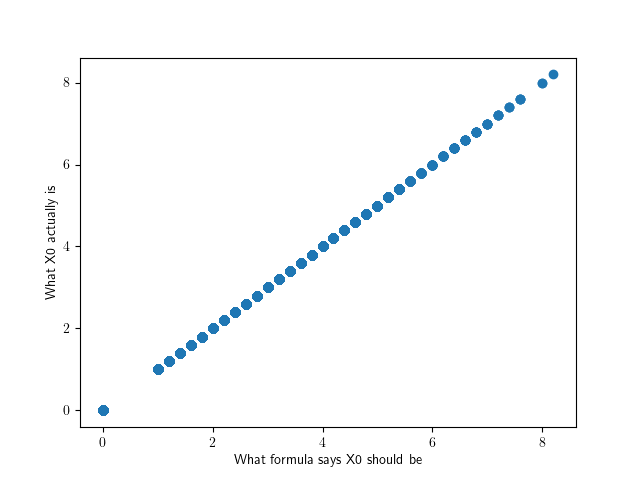

In [8]:
plt.scatter(np.where(X1sum>1,X1sum,0),X0)
plt.xlabel("What formula says X0 should be")
plt.ylabel("What X0 actually is")

(array([3.53210e+04, 2.18765e+05, 3.75109e+05, 2.65193e+05, 1.00511e+05,
        2.63880e+04, 5.53200e+03, 8.97000e+02, 1.23000e+02, 9.00000e+00]),
 array([ 0. ,  1.9,  3.8,  5.7,  7.6,  9.5, 11.4, 13.3, 15.2, 17.1, 19. ]),
 <BarContainer object of 10 artists>)

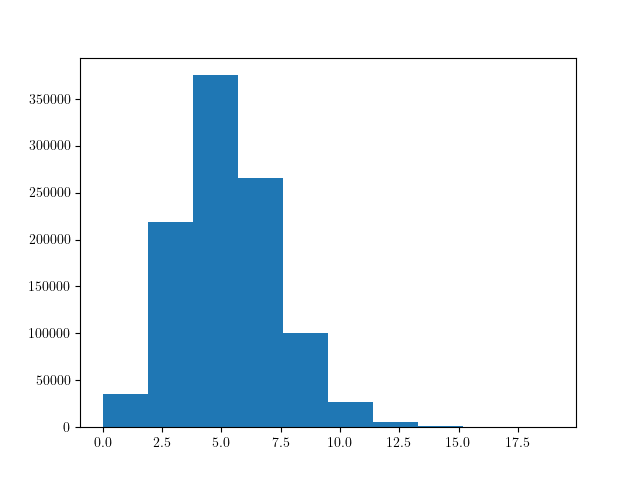

In [9]:
plt.hist(np.array(np.sum(adjacency,axis=0)).ravel())

# construct nefarious edges

In [10]:
nefarious_radius=10 # can set this to something besides 30 to stress-test the network
loc=ad.obs[['Centroid_X','Centroid_Y']].values
rows=[]
cols=[]
for nm in tqdm.notebook.tqdm(ad.obs.tissue_id.cat.categories):
    indicator=ad.obs.tissue_id==nm
    adjacency=sklearn.neighbors.radius_neighbors_graph(loc[indicator],nefarious_radius).tocoo()
    rows.extend(np.where(indicator)[0][adjacency.row])
    cols.extend(np.where(indicator)[0][adjacency.col])
nefarious_adjacency=sp.sparse.coo_matrix((np.ones(len(rows)),(rows,cols)),shape=(len(ad),len(ad))).tocsr()

  0%|          | 0/181 [00:00<?, ?it/s]

# formulate dataset for use with pytorch geometric

In [11]:
def calc_pseudo(edge_index, pos):
    coord1 = pos[edge_index[0]]
    coord2 = pos[edge_index[1]]
    edge_dir = coord2 - coord1
    rho = torch.sqrt(edge_dir[:, 0] ** 2 + edge_dir[:, 1] ** 2).unsqueeze(-1)
    return rho

X=ad.X[:,1:].astype(np.float32)
Y=ad.X[:,[0]].astype(np.float32)
loc=ad.obs[['Centroid_X','Centroid_Y']].values

datalist_train=[]
datalist_test=[]
for tid in tqdm.notebook.tqdm(ad.obs.tissue_id.cat.categories):
    indicator=ad.obs.tissue_id==tid
    subadj=nefarious_adjacency[indicator][:,indicator].tocoo()
    subpos= torch.tensor(loc[indicator].astype(np.float32))
    ei=torch.tensor(np.stack([subadj.row,subadj.col]).astype(int))
    pseudo=calc_pseudo(ei,subpos)/nefarious_radius # number between 0 and 1
    batch=torch_geometric.data.Data(
        x=torch.tensor(np.log1p(X[indicator])), # log transform performed here
        y=torch.tensor(np.log1p(Y[indicator])),
        edge_index=ei,
        edge_attr=pseudo,
    )
    if ad.uns['tissueinfo'].loc[tid].Animal_ID>30:
        datalist_test.append(batch)
    else:
        datalist_train.append(batch)
    

dl_train=torch_geometric.loader.DataLoader(datalist_train,shuffle=True)
dl_test=torch_geometric.loader.DataLoader(datalist_test)

  0%|          | 0/181 [00:00<?, ?it/s]

# check out formulae

1.28355097691387
1.6664983245381269


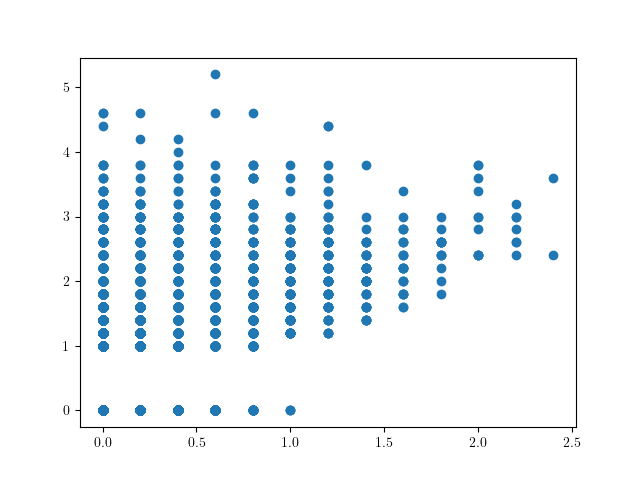

In [12]:
for batch in dl_test:
    break

ei=batch.edge_index.detach().cpu().numpy()
subadj=sp.sparse.coo_matrix((np.ones(ei.shape[1]),ei),shape=(batch.x.shape[0],batch.x.shape[0]))
x=batch.x.detach().cpu().numpy()
y=batch.y.detach().cpu().numpy()

x1s=np.exp(x[:,0])-1
x1sums=subadj@x1s+x1s
x0s=np.exp(y[:,0])-1
plt.scatter(x1sums,x0s)

x1sums_clipped=np.where(x1sums>.997,x1sums,0)

print(np.mean((x1sums-x0s)**2))
print(np.mean((x1sums_clipped-x0s)**2))

# try to learn with GMMconv

In [13]:
class DenseReluGMMConvNetwork(torch.nn.Module):
    def __init__(
        self,
        sizes,
        edge_dim,
        n_kernels,
        **gmmargs
    ):
        super().__init__()

        lst = []
        for i in range(len(sizes) - 1):
            gmmc = torch_geometric.nn.GMMConv(
                sizes[i], sizes[i + 1], dim=edge_dim,kernel_size=n_kernels,
                aggr='mean'
            )
            lst.append(gmmc)
            
        self.gmms = torch.nn.ModuleList(lst)

    def forward(self, vals, edges, pseudo):
        orig_vals = vals
        for i, gmmlayer in enumerate(self.gmms):
            old_vals = vals
            new_vals = gmmlayer(old_vals, edges, pseudo)
            
            if (i != len(self.gmms) - 1):
                new_vals = torch.relu(new_vals)
                
            vals = new_vals

        return vals

class MSEPredictor(pl.LightningModule):
    def __init__(self,n,lr=1e-3):
        super().__init__()
        self.save_hyperparameters()
        
        self.net=DenseReluGMMConvNetwork([n,128,128,128,1],edge_dim=1,n_kernels=5)
        
    def calc_lossinfo(self,batch):
        guess=self.net(batch.x,batch.edge_index,batch.edge_attr)
        loss=torch.mean((guess-batch.y)**2)
        return dict(
            loss=loss
        )
        
    def training_step(self, batch, batch_idx):
        info=self.calc_lossinfo(batch)
        self.log('train_loss',info['loss'],prog_bar=True,batch_size=1)
        return info['loss']
    
    def validation_step(self, batch, batch_idx):
        info=self.calc_lossinfo(batch)
        self.log('val_loss',info['loss'],prog_bar=True,batch_size=1)
        return info['loss']
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        return optimizer

In [14]:
if os.path.exists('lightning_logs/version_0'):
    shutil.rmtree('lightning_logs/version_0')

logger=pl.loggers.CSVLogger('.',version=0)
trainer = pl.Trainer(
    max_epochs=10,accelerator='gpu',
    devices=1,logger=logger,log_every_n_steps=1,
)

model=MSEPredictor(ad.shape[1]-1,lr=1e-3)

trainer.fit(model,train_dataloaders=dl_train,val_dataloaders=dl_test)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4]

  | Name | Type                    | Params
-------------------------------------------------
0 | net  | DenseReluGMMConvNetwork | 320 K 
-------------------------------------------------
320 K     Trainable params
0         Non-trainable params
320 K     Total params
1.283     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


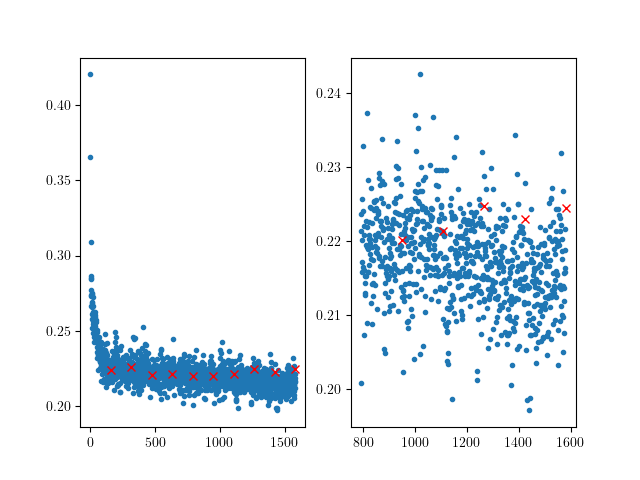

In [15]:
df=pd.read_csv('lightning_logs/version_0/metrics.csv')
n=len(df)

plt.subplot(1,2,1)
plt.plot(df['train_loss'].dropna().index,df['train_loss'].dropna(),'.')
plt.plot(df['val_loss'].dropna().index,df['val_loss'].dropna(),'rx')

plt.subplot(1,2,2)
df2=df.iloc[n//2:]
plt.plot(df2['train_loss'].dropna().index,df2['train_loss'].dropna(),'.')
plt.plot(df2['val_loss'].dropna().index,df2['val_loss'].dropna(),'rx')

# plt.xlim(250,None)
# plt.ylim(1e6,1.5e6)

$\uparrow$ that's not converged.  Needs more epochs.  But anyway, it doesn't run out of RAM.

  0%|          | 0/24 [00:00<?, ?it/s]

(array([4., 1., 3., 3., 2., 5., 3., 1., 0., 2.]),
 array([0.21678354, 0.21853208, 0.22028062, 0.22202917, 0.22377771,
        0.22552625, 0.22727479, 0.22902334, 0.23077188, 0.23252042,
        0.23426896]),
 <BarContainer object of 10 artists>)

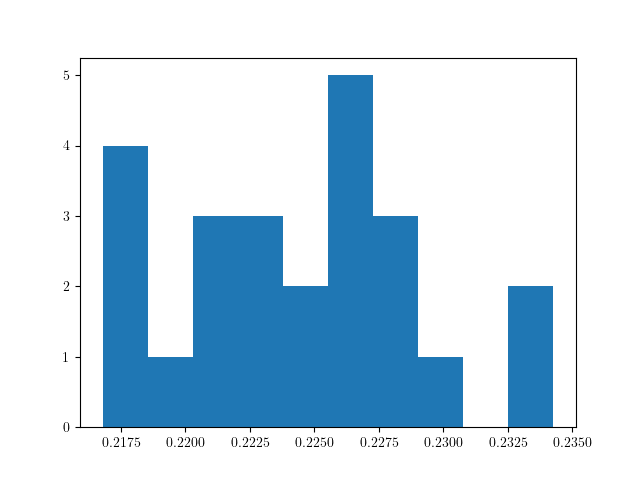

In [16]:
# get final losses for each validation tissue
losses=[]
for batch in tqdm.notebook.tqdm(dl_test):
    losses.append(float(model.calc_lossinfo(batch)['loss'].detach().cpu().numpy()) )
plt.hist(losses)

  0%|          | 0/24 [00:00<?, ?it/s]

Text(0.5, 1.0, 'GCN \nMSE 0.22453051805496216')

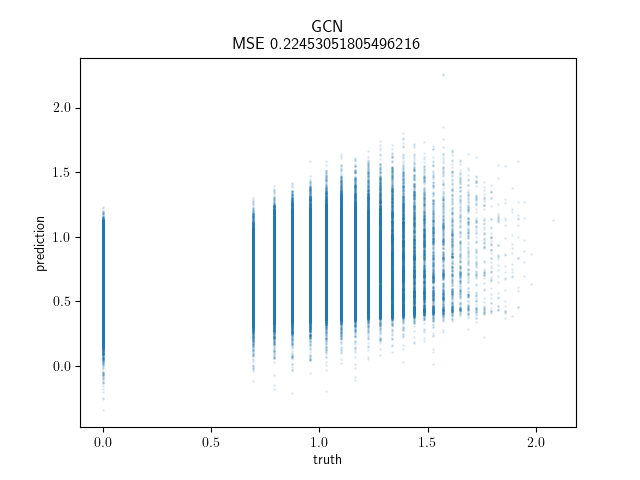

In [17]:
# get final losses across all cells
preds=[]
truths=[]
for batch in tqdm.notebook.tqdm(dl_test):
    preds.append(model.net(batch.x,batch.edge_index,batch.edge_attr).detach().cpu().numpy().ravel())
    truths.append(batch.y.detach().cpu().numpy().ravel())
preds=np.concatenate(preds)
truths=np.concatenate(truths)

plt.scatter(truths,preds,s=1,alpha=.1)
np.mean((preds-truths)**2)

plt.ylabel("prediction")
plt.xlabel("truth")
plt.title(f"GCN \nMSE {np.mean((preds-truths)**2)}")

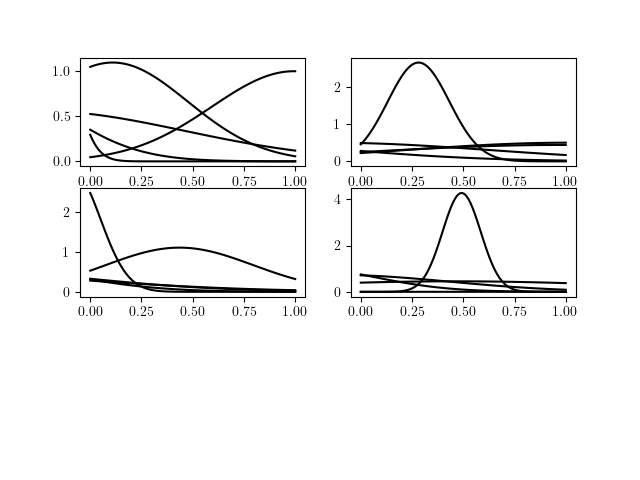

In [18]:
# plot kernels at each layer
xs=np.r_[0:1:100j]
for i,gmm in enumerate(model.net.gmms):
    plt.subplot(3,2,i+1)
    for mu,sig in zip(gmm.mu.detach().cpu().numpy().ravel(),gmm.sigma.detach().cpu().numpy().ravel()):
        sig=np.abs(sig)
        plt.plot(xs,sp.stats.norm.pdf(xs,loc=mu,scale=sig),color='black')

In [19]:
nefarious_radius=30 # can set this to something besides 30 to stress-test the network
loc=ad.obs[['Centroid_X','Centroid_Y']].values
rows=[]
cols=[]
for nm in tqdm.notebook.tqdm(ad.obs.tissue_id.cat.categories):
    indicator=ad.obs.tissue_id==nm
    adjacency=sklearn.neighbors.radius_neighbors_graph(loc[indicator],nefarious_radius).tocoo()
    rows.extend(np.where(indicator)[0][adjacency.row])
    cols.extend(np.where(indicator)[0][adjacency.col])
nefarious_adjacency=sp.sparse.coo_matrix((np.ones(len(rows)),(rows,cols)),shape=(len(ad),len(ad))).tocsr()

  0%|          | 0/181 [00:00<?, ?it/s]

In [20]:
with h5py.File("../data/raw/synth0.hdf5", "r") as h5f:
    expression = h5f["expression"][:]

In [21]:
def calc_pseudo(edge_index, pos):
    coord1 = pos[edge_index[0]]
    coord2 = pos[edge_index[1]]
    edge_dir = coord2 - coord1
    rho = torch.sqrt(edge_dir[:, 0] ** 2 + edge_dir[:, 1] ** 2).unsqueeze(-1)
    return rho

X=expression[:,1:].astype(np.float32)
Y=expression[:,[0]].astype(np.float32)
loc=ad.obs[['Centroid_X','Centroid_Y']].values

datalist_train=[]
datalist_test=[]
for tid in tqdm.notebook.tqdm(ad.obs.tissue_id.cat.categories):
    indicator=ad.obs.tissue_id==tid
    subadj=nefarious_adjacency[indicator][:,indicator].tocoo()
    subpos= torch.tensor(loc[indicator].astype(np.float32))
    ei=torch.tensor(np.stack([subadj.row,subadj.col]).astype(int))
    pseudo=calc_pseudo(ei,subpos)/nefarious_radius # number between 0 and 1
    batch=torch_geometric.data.Data(
        x=torch.tensor(np.log1p(X[indicator])), # log transform performed here
        y=torch.tensor(np.log1p(Y[indicator])),
        edge_index=ei,
        edge_attr=pseudo,
    )
    if ad.uns['tissueinfo'].loc[tid].Animal_ID>30:
        datalist_test.append(batch)
    else:
        datalist_train.append(batch)
    

dl_train=torch_geometric.loader.DataLoader(datalist_train,shuffle=True)
dl_test=torch_geometric.loader.DataLoader(datalist_test)

  0%|          | 0/181 [00:00<?, ?it/s]

# try to learn with lightgbm

In [22]:
# extract data back OUT of the torch datastructures
 
def extract_from_pyg(batch):
    subx=batch.x.cpu().detach().numpy()
    suby=batch.y.cpu().detach().numpy()
    
    ei=batch.edge_index.cpu().detach().numpy()
    subadj=sp.sparse.coo_matrix((np.ones(ei.shape[1]),(ei[0],ei[1])),shape=(subx.shape[0],subx.shape[0]))
    
    covariates=(subadj@subx) + subx 
    covariates=np.concatenate((subx, subadj@subx), axis=1)
    covariates=subx
    
    return covariates,suby.ravel()

lightgbm_X=[]
lightgbm_Y=[]
for batch in tqdm.notebook.tqdm(dl_train):
    covariates,suby=extract_from_pyg(batch)
    print(covariates.shape, suby.shape)
    lightgbm_X.append(covariates)
    lightgbm_Y.append(suby)
lightgbm_X_train=np.concatenate(lightgbm_X,axis=0)
lightgbm_Y_train=np.concatenate(lightgbm_Y,axis=0)

lightgbm_X=[]
lightgbm_Y=[]
for batch in tqdm.notebook.tqdm(dl_test):
    covariates,suby=extract_from_pyg(batch)
    lightgbm_X.append(covariates)
    lightgbm_Y.append(suby)
    
lightgbm_X_test=np.concatenate(lightgbm_X,axis=0)
lightgbm_Y_test=np.concatenate(lightgbm_Y,axis=0)

  0%|          | 0/157 [00:00<?, ?it/s]

(5620, 160) (5620,)
(6051, 160) (6051,)
(5986, 160) (5986,)
(5584, 160) (5584,)
(5381, 160) (5381,)
(5434, 160) (5434,)
(6011, 160) (6011,)
(5696, 160) (5696,)
(5799, 160) (5799,)
(5765, 160) (5765,)
(5280, 160) (5280,)
(5819, 160) (5819,)
(5261, 160) (5261,)
(5556, 160) (5556,)
(5511, 160) (5511,)
(5790, 160) (5790,)
(5653, 160) (5653,)
(5392, 160) (5392,)
(5862, 160) (5862,)
(5970, 160) (5970,)
(5329, 160) (5329,)
(5492, 160) (5492,)
(5727, 160) (5727,)
(6105, 160) (6105,)
(5956, 160) (5956,)
(5452, 160) (5452,)
(5451, 160) (5451,)
(5619, 160) (5619,)
(6200, 160) (6200,)
(5711, 160) (5711,)
(5141, 160) (5141,)
(5504, 160) (5504,)
(5223, 160) (5223,)
(5403, 160) (5403,)
(6144, 160) (6144,)
(5961, 160) (5961,)
(4877, 160) (4877,)
(6135, 160) (6135,)
(4828, 160) (4828,)
(5951, 160) (5951,)
(5770, 160) (5770,)
(5857, 160) (5857,)
(5555, 160) (5555,)
(5676, 160) (5676,)
(4807, 160) (4807,)
(5880, 160) (5880,)
(6398, 160) (6398,)
(6000, 160) (6000,)
(6342, 160) (6342,)
(6417, 160) (6417,)


  0%|          | 0/24 [00:00<?, ?it/s]

In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(lightgbm_X_train)
lightgbm_X_train = scaler.transform(lightgbm_X_train)
lightgbm_X_test = scaler.transform(lightgbm_X_test)
gbm=sklearn.ensemble.HistGradientBoostingRegressor(verbose=1)
gbm.fit(lightgbm_X_train,lightgbm_Y_train)

Binning 1.029 GB of training data: 3.258 s
Binning 0.114 GB of validation data: 0.149 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 31 leaves, max depth = 8, train loss: 0.12793, val loss: 0.12823, in 0.135s
[2/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.12584, val loss: 0.12609, in 0.137s
[3/100] 1 tree, 31 leaves, max depth = 9, train loss: 0.12415, val loss: 0.12435, in 0.130s
[4/100] 1 tree, 31 leaves, max depth = 12, train loss: 0.12278, val loss: 0.12294, in 0.117s
[5/100] 1 tree, 31 leaves, max depth = 9, train loss: 0.12167, val loss: 0.12179, in 0.128s
[6/100] 1 tree, 31 leaves, max depth = 14, train loss: 0.12077, val loss: 0.12086, in 0.122s
[7/100] 1 tree, 31 leaves, max depth = 13, train loss: 0.12003, val loss: 0.12010, in 0.136s
[8/100] 1 tree, 31 leaves, max depth = 12, train loss: 0.11944, val loss: 0.11949, in 0.116s
[9/100] 1 tree, 31 leaves, max depth = 9, train loss: 0.11896, val loss: 0.11899, in 0.110s
[10/100] 1 tree, 31 leaves, max depth = 8, tra

HistGradientBoostingRegressor(verbose=1)

In [24]:
gbm=sklearn.ensemble.HistGradientBoostingRegressor(verbose=1)
gbm.fit(lightgbm_X_train,lightgbm_Y_train)

Binning 1.029 GB of training data: 3.323 s
Binning 0.114 GB of validation data: 0.151 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 31 leaves, max depth = 10, train loss: 0.12793, val loss: 0.12824, in 0.145s
[2/100] 1 tree, 31 leaves, max depth = 9, train loss: 0.12583, val loss: 0.12614, in 0.124s
[3/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.12413, val loss: 0.12444, in 0.113s
[4/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.12276, val loss: 0.12306, in 0.122s
[5/100] 1 tree, 31 leaves, max depth = 7, train loss: 0.12164, val loss: 0.12194, in 0.118s
[6/100] 1 tree, 31 leaves, max depth = 9, train loss: 0.12073, val loss: 0.12103, in 0.130s
[7/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.12000, val loss: 0.12029, in 0.121s
[8/100] 1 tree, 31 leaves, max depth = 15, train loss: 0.11940, val loss: 0.11970, in 0.128s
[9/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.11892, val loss: 0.11922, in 0.117s
[10/100] 1 tree, 31 leaves, max depth = 13, t

HistGradientBoostingRegressor(verbose=1)

In [25]:
lightgbm_preds=gbm.predict(lightgbm_X_test)

Text(0.5, 1.0, 'lightgbm\nMSE 0.23403468713851064')

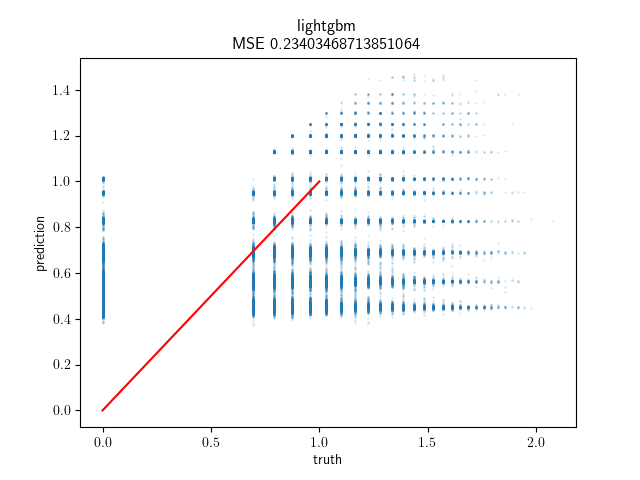

In [26]:
plt.scatter(lightgbm_Y_test,lightgbm_preds,s=1,alpha=.1)

plt.plot([0,1],[0,1],'r-')

plt.ylabel("prediction")
plt.xlabel("truth")
plt.title(f"lightgbm\nMSE {np.mean((lightgbm_preds-lightgbm_Y_test)**2)}")

In [27]:
# pylint: disable=invalid-name, too-many-branches, too-many-statements, unspecified-encoding, R0801
import pickle
import json
import shap
import anndata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import scipy.sparse.linalg
from scipy.spatial import cKDTree
import torch
import h5py
import tqdm.notebook
import sklearn.neighbors
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV


rng = np.random.default_rng()


original_url = "https://datadryad.org/stash/downloads/file_stream/67671"
csv_location = "data/spatial/moffit_merfish/original_file.csv"
h5ad_location = "data/spatial/moffit_merfish/original_file.h5ad"
connectivity_matrix_template = "data/spatial/moffit_merfish/connectivity_%d%s.h5ad"
genetypes_location = "data/spatial/moffit_merfish/genetypes.pkl"

In [36]:
dataframe = pd.read_csv(csv_location)

dct = {}
for colnm, dtype in zip(dataframe.keys()[:9], dataframe.dtypes[:9]):
    if dtype.kind == "O":
        dct[colnm] = np.require(dataframe[colnm], dtype="U36")
    else:
        dct[colnm] = np.require(dataframe[colnm])
# change expression here to make it synthetic
expression = np.array(dataframe[dataframe.keys()[9:]]).astype(np.float64)
gene_names = np.array(dataframe.keys()[9:], dtype="U80")
cellid = dct.pop("Cell_ID")

ad = anndata.AnnData(
    X=expression,
    var=pd.DataFrame(index=gene_names),
    obs=pd.DataFrame(dct, index=cellid),
)

ad.write_h5ad(h5ad_location)

ligands = np.array(
    [
        "Cbln1",
        "Cxcl14",
        "Cbln2",
        "Vgf",
        "Scg2",
        "Cartpt",
        "Tac2",
        "Bdnf",
        "Bmp7",
        "Cyr61",
        "Fn1",
        "Fst",
        "Gad1",
        "Ntng1",
        "Pnoc",
        "Selplg",
        "Sema3c",
        "Sema4d",
        "Serpine1",
        "Adcyap1",
        "Cck",
        "Crh",
        "Gal",
        "Gnrh1",
        "Nts",
        "Oxt",
        "Penk",
        "Sst",
        "Tac1",
        "Trh",
        "Ucn3",
    ]
)

receptors = np.array(
    [
        "Crhbp",
        "Gabra1",
        "Gpr165",
        "Glra3",
        "Gabrg1",
        "Adora2a",
        "Avpr1a",
        "Avpr2",
        "Brs3",
        "Calcr",
        "Cckar",
        "Cckbr",
        "Crhr1",
        "Crhr2",
        "Galr1",
        "Galr2",
        "Grpr",
        "Htr2c",
        "Igf1r",
        "Igf2r",
        "Kiss1r",
        "Lepr",
        "Lpar1",
        "Mc4r",
        "Npy1r",
        "Npy2r",
        "Ntsr1",
        "Oprd1",
        "Oprk1",
        "Oprl1",
        "Oxtr",
        "Pdgfra",
        "Prlr",
        "Ramp3",
        "Rxfp1",
        "Slc17a7",
        "Slc18a2",
        "Tacr1",
        "Tacr3",
        "Trhr",
    ]
)

response_genes = np.array(
    [
        "Ace2",
        "Aldh1l1",
        "Amigo2",
        "Ano3",
        "Aqp4",
        "Ar",
        "Arhgap36",
        "Baiap2",
        "Ccnd2",
        "Cd24a",
        "Cdkn1a",
        "Cenpe",
        "Chat",
        "Coch",
        "Col25a1",
        "Cplx3",
        "Cpne5",
        "Creb3l1",
        "Cspg5",
        "Cyp19a1",
        "Cyp26a1",
        "Dgkk",
        "Ebf3",
        "Egr2",
        "Ermn",
        "Esr1",
        "Etv1",
        "Fbxw13",
        "Fezf1",
        "Gbx2",
        "Gda",
        "Gem",
        "Gjc3",
        "Greb1",
        "Irs4",
        "Isl1",
        "Klf4",
        "Krt90",
        "Lmod1",
        "Man1a",
        "Mbp",
        "Mki67",
        "Mlc1",
        "Myh11",
        "Ndnf",
        "Ndrg1",
        "Necab1",
        "Nnat",
        "Nos1",
        "Npas1",
        "Nup62cl",
        "Omp",
        "Onecut2",
        "Opalin",
        "Pak3",
        "Pcdh11x",
        "Pgr",
        "Plin3",
        "Pou3f2",
        "Rgs2",
        "Rgs5",
        "Rnd3",
        "Scgn",
        "Serpinb1b",
        "Sgk1",
        "Slc15a3",
        "Slc17a6",
        "Slc17a8",
        "Slco1a4",
        "Sln",
        "Sox4",
        "Sox6",
        "Sox8",
        "Sp9",
        "Synpr",
        "Syt2",
        "Syt4",
        "Sytl4",
        "Th",
        "Tiparp",
        "Tmem108",
        "Traf4",
        "Ttn",
        "Ttyh2",
    ]
)
cell_types = [
    "Ambiguous",
    "Astrocyte",
    "Endothelial 1",
    "Endothelial 2",
    "Endothelial 3",
    "Ependymal",
    "Excitatory",
    "Inhibitory",
    "Microglia",
    "OD Immature 1",
    "OD Immature 2",
    "OD Mature 1",
    "OD Mature 2",
    "OD Mature 3",
    "OD Mature 4",
    "Pericytes",
]

with open(genetypes_location, "rb") as f:
    genetypes = pickle.load(f)

neighset = genetypes["ligands"]
oset = np.r_[genetypes["ligands"], genetypes["receptors"]]
# oset=neighset

# onehot encode cell classes
def oh_encode(lst):
    lst = np.array(lst)
    group_names = np.unique(lst)
    group_indexes = np.zeros((len(lst), len(group_names)), dtype=bool)
    for i, nm in enumerate(group_names):
        group_indexes[lst == nm, i] = True
    return group_names, group_indexes


cell_classes, cell_class_onehots = oh_encode(ad.obs["Cell_class"])

# a function to construct a prediction problem for a subset of cells


def construct_problem(
    mask,
    target_gene,
    neighbor_genes,
    self_genes,
    filter_excitatory=False,
    synthetic_mode=0,
):
    """
    mask -- set of cells
    target_gene -- gene to predict
    neighbor_genes -- names of genes which will be read from neighbors
    self_genes -- names of genes which will be read from target cell
    """

    collected_feature_names = []

    # load subset of data relevant to mask
    local_edges = connectivity_matrix[mask][:, mask]  # get edges for subset
    local_pos = ad.obs[mask][['Centroid_X','Centroid_Y']]

    true_local_edges = true_connectivity_matrix[mask][:, mask]  # get edges for subset
    pos = cKDTree(local_pos)
    true_local_distances = pos.sparse_distance_matrix(cKDTree(local_pos), true_radius)
    selfset_idxs = [
        gene_lookup[x] for x in self_genes
    ]  # collect the column indexes associated with them

    with h5py.File(f"{basefn}/synth{synthetic_mode}.hdf5", "r") as data:
        local_processed_expression = data["expression"][:].astype("float64")[mask]
    selfset_exprs = local_processed_expression[
        :, selfset_idxs
    ]  # collect ligand and receptor expressions
    local_processed_expression = np.log1p(local_processed_expression)
    selfset_exprs = np.log1p(selfset_exprs)
    collected_feature_names += list(self_genes)

    neighborset_idxs = [1] + [
        gene_lookup[x] for x in neighbor_genes
    ]  # collect the column indexes associated with them
    neighset_exprs = local_processed_expression[
        :, neighborset_idxs
    ] # collect ligand and receptor expressions

    collected_feature_names += [x + " from Neighbors" for x in neighbor_genes]

    n_neighs = local_edges @ np.ones(local_edges.shape[0])
    # SANITY CHECK REMOVES DIVISION
    neigh_avgs = (local_edges @ neighset_exprs)# / n_neighs[
#         :, None
#     ]  # average ligand/receptor for neighbors
    print(neighset_exprs)
    print(neighborset_idxs)
    print(neigh_avgs)
    print(np.max(local_edges))

    neigh_cellclass_avgs = (local_edges @ cell_class_onehots[mask]) / n_neighs[
        :, None
    ]  # celltype simplex

    collected_feature_names += [f"Cell Class {cell_types[x]}" for x in range(16)]

    positions = np.array(ad.obs[["Centroid_X", "Centroid_Y", "Bregma"]])[
        mask
    ]  # get positions

    collected_feature_names += ["Centroid_X", "Centroid_Y", "Bregma"]

    covariates = np.c_[
        local_processed_expression[:, 1:], neigh_avgs, neigh_cellclass_avgs, positions
    ]  # collect all covariates
    covariates = np.c_[
        local_processed_expression[:, 1:], neigh_avgs#, neigh_avgs, neigh_cellclass_avgs, positions
    ]  # collect all covariates
    predict = local_processed_expression[
        :, gene_lookup[target_gene]
    ]  # collect what we're supposed to predict

    if filter_excitatory:

        excites = (ad.obs["Cell_class"] == "Excitatory")[
            mask
        ]  # get the subset of these cells which are excitatory
        covariates = covariates[excites]  # subset to excites
        predict = predict[excites]  # subset to excites

    return covariates, predict, collected_feature_names


dataframe = pd.read_csv(csv_location)

dct = {}
for colnm, dtype in zip(dataframe.keys()[:9], dataframe.dtypes[:9]):
    if dtype.kind == "O":
        dct[colnm] = np.require(dataframe[colnm], dtype="U36")
    else:
        dct[colnm] = np.require(dataframe[colnm])
expression = np.array(dataframe[dataframe.keys()[9:]]).astype(np.float64)
gene_names = np.array(dataframe.keys()[9:], dtype="U80")
cellid = dct.pop("Cell_ID")

ad = anndata.AnnData(
    X=expression,
    var=pd.DataFrame(index=gene_names),
    obs=pd.DataFrame(dct, index=cellid),
)

ad.write_h5ad(h5ad_location)

ad = anndata.read_h5ad(h5ad_location)
animal_ids = np.unique(ad.obs["Animal_ID"])
bregmas = np.unique(ad.obs["Bregma"])
tissue_id = np.zeros(len(ad), dtype=int)
n_tissues = 0

for aid in animal_ids:
    for bregma in bregmas:
        good = (ad.obs["Animal_ID"] == aid) & (ad.obs["Bregma"] == bregma)
        if np.sum(good) > 0:
            tissue_id[good] = n_tissues
            n_tissues += 1
ad.obs["Tissue_ID"] = tissue_id
ad.write_h5ad(h5ad_location)

# Building Radius 30 Graph (Ground Truth)
ad = anndata.read_h5ad(h5ad_location)
row = np.zeros(0, dtype=int)
col = np.zeros(0, dtype=int)
true_radius = 30

for tid in tqdm.notebook.tqdm(np.unique(ad.obs["Tissue_ID"])):
    good = ad.obs["Tissue_ID"] == tid
    pos = np.array(ad.obs[good][["Centroid_X", "Centroid_Y"]])
    idxs = np.where(good)[0]
    p = sklearn.neighbors.KDTree(pos)
    true_edges, true_distances = p.query_radius(
        pos, r=true_radius, return_distance=True
    )
    true_distances = np.concatenate(
        [
            np.c_[
                np.repeat(i, len(true_distances[i])),
                list(true_distances[i]),
            ]
            for i in range(len(true_distances))
        ],
        axis=0,
    )
    true_edges = np.concatenate(
        [
            np.c_[
                np.repeat(i, len(true_edges[i])),
                list(true_edges[i]),
            ]
            for i in range(len(true_edges))
        ],
        axis=0,
    )
    col = np.r_[
        col,
        idxs[[y for (x, y) in true_edges]]
    ]
    row = np.r_[
        row,
        idxs[[x for (x, y) in true_edges]]
    ]

E = (
    sp.sparse.coo_matrix((np.ones(len(col)), (row, col)), shape=(len(ad), len(ad)))
).tocsr()

anndata.AnnData(E).write_h5ad(connectivity_matrix_template % (true_radius, "rad"))

# load data
# These are set above. You can change these here if you want though.
# radius=60
# mode="rad"
ad = anndata.read_h5ad(h5ad_location)
true_connectivity_matrix = anndata.read_h5ad(
    connectivity_matrix_template % (true_radius, "rad")
).X
gene_lookup = {x: i for (i, x) in enumerate(ad.var.index)}

results_dict = {}

response_gene = "Ace2"  # make the response gene the first response

X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


  0%|          | 0/181 [00:00<?, ?it/s]

X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


In [37]:
synth_experiment=0
radius_value=30

# Build the Current Radius Graph
ad = anndata.read_h5ad(h5ad_location)
row = np.zeros(0, dtype=int)
col = np.zeros(0, dtype=int)
radius = radius_value

for tid in tqdm.notebook.tqdm(np.unique(ad.obs["Tissue_ID"])):
    good = ad.obs["Tissue_ID"] == tid
    pos = np.array(ad.obs[good][["Centroid_X", "Centroid_Y"]])
    idxs = np.where(good)[0]
    p = sklearn.neighbors.KDTree(pos)
    # E=p.query_ball_point(pos, r=radius, return_sorted=False)
    edges, distances = p.query_radius(pos, r=radius, return_distance=True)
    distances = np.concatenate(
        [
            np.c_[
                np.repeat(i, len(distances[i])),
                list(distances[i]),
            ]
            for i in range(len(distances))
        ],
        axis=0,
    )
    edges = np.concatenate(
        [
            np.c_[
                np.repeat(i, len(edges[i])),
                list(edges[i]),
            ]
            for i in range(len(edges))
        ],
        axis=0,
    )
    col = np.r_[
        col,
        idxs[[y for (x, y) in edges]]
    ]
    row = np.r_[
        row,
        idxs[[x for (x, y) in edges]]
    ]

E = (
    sp.sparse.coo_matrix(
        (np.ones(len(col)), (row, col)), shape=(len(ad), len(ad))
    )
).tocsr()

anndata.AnnData(E).write_h5ad(connectivity_matrix_template % (radius, "rad"))

ad = anndata.read_h5ad(h5ad_location)
connectivity_matrix = anndata.read_h5ad(
    connectivity_matrix_template % (radius, "rad")
).X
gene_lookup = {x: i for (i, x) in enumerate(ad.var.index)}

  0%|          | 0/181 [00:00<?, ?it/s]

X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


In [38]:
trainX, trainY, feature_names = construct_problem(
    (ad.obs["Animal_ID"] <= 30),
    response_gene,
    neighset,
    oset,
    synthetic_mode=synth_experiment,
)
testX, testY, feature_names = construct_problem(
    (ad.obs["Animal_ID"] > 30),
    response_gene,
    neighset,
    oset,
    synthetic_mode=synth_experiment,
)
print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

# df = pd.DataFrame(testX, columns=feature_names)
df = pd.DataFrame(testX)

#         scaler = StandardScaler().fit(trainX)
#         trainX = scaler.transform(trainX)
#         testX = scaler.transform(testX)

model = HistGradientBoostingRegressor(verbose=1, max_iter=10000)
model.fit(trainX, trainY)

[[0.18232156 0.         0.         ... 0.18232156 0.         0.        ]
 [0.69314718 0.18232156 0.58778667 ... 0.         0.18232156 0.        ]
 [0.18232156 0.         0.18232156 ... 0.         0.         0.        ]
 ...
 [0.         0.58778667 0.18232156 ... 0.         0.18232156 0.18232156]
 [0.18232156 0.         0.         ... 0.         0.33647224 0.18232156]
 [0.47000364 0.18232156 0.         ... 0.33647224 0.         0.        ]]
[1, 20, 38, 21, 160, 152, 141, 156, 11, 17, 41, 50, 51, 54, 88, 103, 112, 113, 114, 116, 140, 142, 143, 145, 146, 149, 150, 151, 154, 155, 158, 159]
[[1.0577903  0.70111536 0.77010823 ... 2.06939123 0.36464312 0.18232156]
 [1.0577903  0.70111536 0.77010823 ... 2.06939123 0.36464312 0.18232156]
 [1.39426254 0.70111536 0.95242979 ... 2.58818503 0.36464312 0.18232156]
 ...
 [0.67294448 0.92425891 0.36464312 ... 0.36464312 0.54696468 1.30465041]
 [0.18232156 0.         0.18232156 ... 0.78845738 0.33647224 0.18232156]
 [0.47000364 0.18232156 0.18232156 ..

[64/10000] 1 tree, 31 leaves, max depth = 12, train loss: 0.00029, val loss: 0.00029, in 0.164s
[65/10000] 1 tree, 31 leaves, max depth = 11, train loss: 0.00028, val loss: 0.00029, in 0.155s
[66/10000] 1 tree, 31 leaves, max depth = 12, train loss: 0.00028, val loss: 0.00029, in 0.160s
[67/10000] 1 tree, 31 leaves, max depth = 14, train loss: 0.00028, val loss: 0.00029, in 0.147s
[68/10000] 1 tree, 31 leaves, max depth = 14, train loss: 0.00028, val loss: 0.00029, in 0.140s
[69/10000] 1 tree, 31 leaves, max depth = 8, train loss: 0.00028, val loss: 0.00029, in 0.141s
[70/10000] 1 tree, 31 leaves, max depth = 9, train loss: 0.00028, val loss: 0.00029, in 0.117s
[71/10000] 1 tree, 31 leaves, max depth = 11, train loss: 0.00028, val loss: 0.00029, in 0.175s
[72/10000] 1 tree, 31 leaves, max depth = 10, train loss: 0.00028, val loss: 0.00029, in 0.160s
[73/10000] 1 tree, 31 leaves, max depth = 14, train loss: 0.00028, val loss: 0.00029, in 0.148s
[74/10000] 1 tree, 31 leaves, max depth = 

[149/10000] 1 tree, 31 leaves, max depth = 12, train loss: 0.00026, val loss: 0.00027, in 0.104s
[150/10000] 1 tree, 31 leaves, max depth = 16, train loss: 0.00026, val loss: 0.00027, in 0.081s
[151/10000] 1 tree, 31 leaves, max depth = 13, train loss: 0.00026, val loss: 0.00027, in 0.119s
[152/10000] 1 tree, 31 leaves, max depth = 14, train loss: 0.00026, val loss: 0.00027, in 0.102s
[153/10000] 1 tree, 31 leaves, max depth = 10, train loss: 0.00026, val loss: 0.00027, in 0.129s
[154/10000] 1 tree, 31 leaves, max depth = 12, train loss: 0.00026, val loss: 0.00027, in 0.129s
[155/10000] 1 tree, 31 leaves, max depth = 14, train loss: 0.00026, val loss: 0.00027, in 0.108s
[156/10000] 1 tree, 31 leaves, max depth = 12, train loss: 0.00026, val loss: 0.00027, in 0.133s
[157/10000] 1 tree, 31 leaves, max depth = 12, train loss: 0.00026, val loss: 0.00027, in 0.097s
[158/10000] 1 tree, 31 leaves, max depth = 12, train loss: 0.00026, val loss: 0.00027, in 0.092s
[159/10000] 1 tree, 31 leaves,

[234/10000] 1 tree, 31 leaves, max depth = 14, train loss: 0.00025, val loss: 0.00027, in 0.082s
[235/10000] 1 tree, 31 leaves, max depth = 11, train loss: 0.00025, val loss: 0.00027, in 0.115s
[236/10000] 1 tree, 31 leaves, max depth = 11, train loss: 0.00025, val loss: 0.00027, in 0.087s
[237/10000] 1 tree, 31 leaves, max depth = 11, train loss: 0.00025, val loss: 0.00027, in 0.084s
[238/10000] 1 tree, 31 leaves, max depth = 12, train loss: 0.00024, val loss: 0.00027, in 0.124s
[239/10000] 1 tree, 31 leaves, max depth = 10, train loss: 0.00024, val loss: 0.00027, in 0.093s
[240/10000] 1 tree, 31 leaves, max depth = 14, train loss: 0.00024, val loss: 0.00027, in 0.103s
[241/10000] 1 tree, 31 leaves, max depth = 12, train loss: 0.00024, val loss: 0.00027, in 0.085s
[242/10000] 1 tree, 31 leaves, max depth = 17, train loss: 0.00024, val loss: 0.00027, in 0.135s
[243/10000] 1 tree, 31 leaves, max depth = 13, train loss: 0.00024, val loss: 0.00027, in 0.127s
[244/10000] 1 tree, 31 leaves,

[319/10000] 1 tree, 31 leaves, max depth = 13, train loss: 0.00024, val loss: 0.00027, in 0.090s
[320/10000] 1 tree, 31 leaves, max depth = 14, train loss: 0.00024, val loss: 0.00027, in 0.114s
[321/10000] 1 tree, 31 leaves, max depth = 13, train loss: 0.00024, val loss: 0.00027, in 0.121s
[322/10000] 1 tree, 31 leaves, max depth = 14, train loss: 0.00024, val loss: 0.00027, in 0.124s
[323/10000] 1 tree, 31 leaves, max depth = 10, train loss: 0.00024, val loss: 0.00027, in 0.119s
[324/10000] 1 tree, 31 leaves, max depth = 15, train loss: 0.00024, val loss: 0.00027, in 0.082s
[325/10000] 1 tree, 31 leaves, max depth = 12, train loss: 0.00024, val loss: 0.00027, in 0.106s
[326/10000] 1 tree, 31 leaves, max depth = 13, train loss: 0.00024, val loss: 0.00027, in 0.122s
[327/10000] 1 tree, 31 leaves, max depth = 13, train loss: 0.00024, val loss: 0.00027, in 0.132s
[328/10000] 1 tree, 31 leaves, max depth = 12, train loss: 0.00024, val loss: 0.00027, in 0.096s
[329/10000] 1 tree, 31 leaves,

HistGradientBoostingRegressor(max_iter=10000, verbose=1)

In [39]:
testX.shape

(134392, 192)

In [40]:
lightgbm_X_test.shape

(134392, 160)

In [33]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(trainX)
trainX = scaler.transform(trainX)
testX = scaler.transform(testX)
gbm=sklearn.ensemble.HistGradientBoostingRegressor(verbose=1)
gbm.fit(trainX,trainY)

Binning 1.235 GB of training data: 3.755 s
Binning 0.137 GB of validation data: 0.242 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 31 leaves, max depth = 12, train loss: 0.12798, val loss: 0.12777, in 0.148s
[2/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.12588, val loss: 0.12567, in 0.168s
[3/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.12418, val loss: 0.12398, in 0.147s
[4/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.12280, val loss: 0.12260, in 0.133s
[5/100] 1 tree, 31 leaves, max depth = 10, train loss: 0.12169, val loss: 0.12149, in 0.135s
[6/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.12078, val loss: 0.12058, in 0.165s
[7/100] 1 tree, 31 leaves, max depth = 9, train loss: 0.12005, val loss: 0.11985, in 0.139s
[8/100] 1 tree, 31 leaves, max depth = 12, train loss: 0.11945, val loss: 0.11926, in 0.140s
[9/100] 1 tree, 31 leaves, max depth = 10, train loss: 0.11897, val loss: 0.11878, in 0.126s
[10/100] 1 tree, 31 leaves, max depth = 13,

HistGradientBoostingRegressor(verbose=1)

In [34]:
testX, lightgbm_X_test

(array([[-0.78897324, -0.78821318, -0.78916325, ...,  0.1099232 ,
          0.1120555 ,  0.11014345],
        [-0.78897324,  0.11209303,  0.87389259, ...,  0.1099232 ,
          1.53357   ,  0.11014345],
        [ 0.11240141, -0.78821318,  0.1119837 , ...,  0.87108777,
         -0.78884433,  1.5289018 ],
        ...,
        [ 1.53466512,  0.11209303, -0.78916325, ..., -0.79034341,
          0.1120555 , -0.78900964],
        [ 0.11240141, -0.78821318, -0.78916325, ..., -0.79034341,
          1.53357   ,  0.87036655],
        [ 3.10905997,  0.87329107, -0.78916325, ..., -0.79034341,
         -0.78884433, -0.78900964]]),
 array([[-0.7889732 ,  0.8732909 ,  2.636803  , ..., -0.78884435,
          0.11014347, -0.7898543 ],
        [-0.7889732 ,  0.11209305, -0.78916323, ..., -0.78884435,
          0.87036645, -0.7898543 ],
        [ 1.5346652 , -0.7882132 ,  0.8738925 , ...,  0.11205552,
         -0.78900963, -0.7898543 ],
        ...,
        [ 0.8745027 ,  0.11209305, -0.78916323, ..., -

In [35]:
from sklearn.preprocessing import StandardScaler
light_gbm_scaler = StandardScaler().fit(lightgbm_X_train)
lightgbm_X_train = scaler.transform(lightgbm_X_train)
lightgbm_X_test = scaler.transform(lightgbm_X_test)
gbm=sklearn.ensemble.HistGradientBoostingRegressor(verbose=1)
gbm.fit(lightgbm_X_train,lightgbm_Y_train)

ValueError: X has 160 features, but StandardScaler is expecting 192 features as input.

In [ ]:
testY

In [ ]:
lightgbm_Y_test